# <span style="color:blue"><div align="center">Topic modeling</div><span>

### In this notebook, we are going to use LDA (Latent Dirichlet Allocation) to answer the following questions:
#### Q1: Given the titles that involve an entity (e.g. United States, China, France ... etc), what are the topics covered by the given dataset involving that entity?
    Examples of titles related to China:
    - Russia, China challenge US with proposal to ban space weapons!
    - China considers ending one-child policy!
    - Chinese Troops Encriple Tibetan Monestaries.   So Hussein was evil for invading Kuweit, but... !
    - Chinese troops surround monasteries in Tibet!
    - Riots break out in Tibetan capital!
    
#### Q2: Given a "title" T, what are the most similar titles to T in the dataset?


In [1]:
import sys, os, re, pprint, time, multiprocessing
import pandas as pd
import numpy as np

import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from collections import defaultdict

from gensim import models, corpora, similarities, matutils
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import AuthorTopicModel
from gensim.models import atmodel
from gensim.similarities import MatrixSimilarity


pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Loading data

In [2]:
data_path = 'Eluvio_DS_Challenge.csv'
df = pd.read_csv(data_path)

print(df.shape[0])

509236


## Preprocessing data/titles, in this step we will perform a series of preprocessing tasks on the title attribute to prepare it for the next steps.

## Preprocessing steps:
### 1. `clean_and_fix`: in this step, we convert each title to its lower case, and do some cleaning steps, such as:
  ####     a. convert abbreviations to their normal form, for exampe 'U.S.' would be replaced with 'united states'
  ####     b. replace characters as '-' and '_' with space ' '
### 2. Remove numbers, symbols ... etc, and only keep English alphbets. This step will filter out articles written in non-English languages
### 3. Tokenizing each title into a list of words 
### 4. Removing stop words
### 5. Lemmatize all words
### 6. Remove short words, where size(word) < 3

In [3]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import WordPunctTokenizer
# for bigrams and trigrams
from gensim.models import Phrases

lemma = nltk.wordnet.WordNetLemmatizer()
stemmer = SnowballStemmer('english')
stop_words = nltk.corpus.stopwords.words('english')


def tokenize_removeStopWords_stem(text):
    # tokenize
    words = WordPunctTokenizer().tokenize(text)
    # remove stop words
    words = [word for word in words if word not in stopwords.words('english')]
    # stem each word
    words = [stemmer.stem(word) for word in words]
    return words

def tokenize_removeStopWords_lemmatize(text):
    # tokenize
    words = WordPunctTokenizer().tokenize(text)
    # remove stop words
    words = [word for word in words if word not in stopwords.words('english')]
    # stem each word
    words = [lemma.lemmatize(word) for word in words]
    return words

def to_lower(txt):
    return txt.lower()

def remove_non_alphabetic(txt):
    regex = re.compile('[^a-zA-Z ]+')
    return regex.sub('', txt)

def de_abbreviate(txt):
    txt = txt.lower()
    
    txt = txt.replace('-', ' ')
    txt = txt.replace('_', ' ')
    
    if txt.startswith('us '):
        txt = 'united states ' + txt[2:]
    if txt.startswith('uk '):
        txt = 'united kindom ' + txt[2:]
    if txt.startswith('un '):
        txt = 'united nations ' + txt[2:]
    if txt.startswith('eu '):
        txt = 'europe ' + txt[2:]
    
    if txt.endswith(' us'):
        txt = txt[0:len(txt) - 2] + ' united states'
    if txt.endswith(' uk'):
        txt = txt[0:len(txt) - 2] + ' united kindom'
    if txt.endswith(' un'):
        txt = txt[0:len(txt) - 2] + ' united nations'
    if txt.endswith(' eu'):
        txt = txt[0:len(txt) - 2] + ' europe'
    
    txt = txt.replace('u.s.', 'united states')
    txt = txt.replace('u.k.', 'united kingdom')
    txt = txt.replace('u.n.', 'united nations')
    txt = txt.replace('e.u.', 'europe')
    
    txt = txt.replace(' us ', 'united states')
    txt = txt.replace(' uk ', 'united kingdom')
    txt = txt.replace(' un ', 'united nations')
    txt = txt.replace(' eu ', 'europe')
    
    return txt

def remove_short_words(title):
    return [word for word in title if len(word) >= 3]

def preprocess(titles):
    start = time.time()
    pool = multiprocessing.Pool()
    
    # remove abbreviations, such as U.S., EU ... etc and replace with the full names
    # note that this function (de_abbreviate) will convert to lower case too
    titles = list(pool.map( de_abbreviate, titles ))
    # remove non-alphabet charaters, yet keep white spaces
    titles = list(pool.map( remove_non_alphabetic, titles ))
    # tokenize, remove stop words, and stem
    titles = list(pool.map( tokenize_removeStopWords_lemmatize, titles ))
    
    titles = list(pool.map( remove_short_words, titles ))
    end = time.time()
    print(f"Runtime of the preprocess function is {end - start}")

    pool.close()
    return (titles)

preprocessed_titles = preprocess(df['title'].to_list())

# compute bigrams
bigram = Phrases(preprocessed_titles, min_count=2, threshold=5)

# Now, append bigrams preprocessed titles
for index in range(len(preprocessed_titles)):
    for token in bigram[preprocessed_titles[index]]:
        if '_' in token:
            # Token is a bigram, add to document.
            preprocessed_titles[index].append(token)


Runtime of the preprocess function is 81.39524817466736


In [4]:
df['preprocessed_title'] = preprocessed_titles
print(df[['title', 'preprocessed_title']][0:5])


                                             title  \
0                Scores killed in Pakistan clashes   
1                 Japan resumes refuelling mission   
2                  US presses Egypt on Gaza border   
3     Jump-start economy: Give health care to all    
4  Council of Europe bashes EU&UN terror blacklist   

                                                                   preprocessed_title  
0                                      [score, killed, pakistan, clash, score_killed]  
1                                                [japan, resume, refuelling, mission]  
2              [united, state, press, egypt, gaza, border, united_state, gaza_border]  
3                 [jump, start, economy, give, health, care, jump_start, health_care]  
4  [council, europe, bash, euun, terror, blacklist, council_europe, terror_blacklist]  


# Next, we build the dictionary, corpus and the mapping from document to author that we will use to train our *AuthorTopicModel* model in gensim

# The function `build_dictioanry_and_corpus()` builds and returns:
## - Dictionary
## - Corpus

In [5]:
def build_dictioanry_and_corpus(df):
    titles = df['preprocessed_title'].to_list()
    dictionary = corpora.Dictionary(titles)
    # filter extremes: we keep all topkens/words in our dictionary regardless of their frequencies
    dictionary.filter_extremes(no_below=1, no_above=1)
    corpus = [dictionary.doc2bow(title_words) for title_words in titles]
    doc2author = dict( zip( range(df.shape[0]), list(df.author.values) ) )
    return dictionary, corpus, doc2author


In [6]:
dictionary, corpus, doc2author = build_dictioanry_and_corpus(df)

# Now, let's look at our dictionary and corpus, and check if there are any empty documents due to preprocessing steps

In [7]:
print('Number of authors: ', len(df.author.unique()))
print('Number of unique words: ', len(dictionary))
print('Number of documents: ', len(corpus))
print('Number of doc2author: ', len(doc2author))

items = list(doc2author.items())#[0:10]

count_empty = 0
empty_docs = list()
for key, value in items:
#     print(key, value)
    corp = corpus[key]
    if not any(corp):
        count_empty += 1
        print('Document # ', key, ' is empty')
        print(corpus[key])
        print('Title: ', df['title'][key])
        print()
        empty_docs.append(key)

print('Empty documents/bag-of-words = ', count_empty)
print(empty_docs)

Number of authors:  85838
Number of unique words:  100000
Number of documents:  509236
Number of doc2author:  509236
Document #  577  is empty
[]
Title:  CHCNK OUT

Document #  1226  is empty
[]
Title:  Najnowsze wydarzenia, fakty i informacje - HotInfos.org

Document #  1368  is empty
[]
Title:  هل كان في يوم.. العرب أخوة؟

Document #  1862  is empty
[]
Title:  Бадминтон: россияне завоевали золото в Румынии

Document #  3690  is empty
[]
Title:  The Touchstone

Document #  4322  is empty
[]
Title:  Как просматривать закрытые страницы вконтакте

Document #  6281  is empty
[]
Title:  Irena Sendler

Document #  6324  is empty
[]
Title:  Mmiss universo - 1952 - 2005

Document #  7368  is empty
[]
Title:  Thinspiration

Document #  8405  is empty
[]
Title:  69, 127

Document #  8873  is empty
[]
Title:  duthel.org

Document #  8986  is empty
[]
Title:  Fiere Belg op zijn einde?

Document #  9116  is empty
[]
Title:   ANGOLO DI MARKINO : UOMINI LIBERI

Document #  9267  is empty
[]
Title:  

# We discover that there are <span style="color:red">151</span> documents/rows with empty bag-of-words and/or bigrams, where their titles were filtered out and emptied during the preprocessing.
# For example, at row with <span style="color:blue">key = 1368</span>, the title is in Arabic language which was filtered during the preprocessing step `remove_non_alphabetic()`.

# What we will do now is removing those <span style="color:red">151</span> rows from the dataset, and rebuild the dictionary and corpus


In [8]:
# 1. First, remove those rows that will result in empty bags-of-words
df.drop(df.index[empty_docs], axis=0, inplace=True)
# reset the index
df.index = range(df.shape[0])
print('New dataframe size is ', df.shape[0])

New dataframe size is  509085


In [9]:
# 2. Next, rebuild the dictionary, corpus, and the document-to-author mapping
dictionary, corpus, doc2author = build_dictioanry_and_corpus(df)

print('Number of authors: ', len(df.author.unique()))
print('Number of unique words: ', len(dictionary))
print('Number of documents: ', len(corpus))
print('Number of doc2author: ', len(doc2author))

Number of authors:  85745
Number of unique words:  100000
Number of documents:  509085
Number of doc2author:  509085


# <span style="color:blue"><div align="center">LDA model training</span>

# After cleaning and preprocessing our dataset, let's train an LDA model capable of discovering topics in the dataset

# Model parameters:
## 1. *`alpha='auto'` and `eta='auto'`*, 'auto' enables automatic fine tuning the alpha and beta parameters of the LDA model from the dataset
## 2. *`passes = 20`*, is the number of passes through the corpus during training (the higher the better)
## 3. *`iterations = 40`*, is the maximum number of iterations through the corpus when inferring the topic distribution of a corpus. (the higher the better)
## 4. `num_topics` is the number of topics to be extracted from the training corpus

# Since LDA requires the `num_topics` hyperparameter beforehand, we will search through different values of `num_topics` for the optimal number of topics that will result in the best topic coherence (check /https://www.aclweb.org/anthology/D12-1087.pdf for more details on topic coherence)
    
# In order to speed-up the training process, we parallelize the training, where the model for each number-of-topics is trained on a separate core

In [10]:
from gensim.models import CoherenceModel

model_list = []
passes = 20
iterations = 40

# this function filters the dataset by a set of kewords that exist in the titles column
def filter_by_entity(df, keywords):
    keys_concat = '|'.join(keywords)
    p = re.compile(keys_concat, flags=re.IGNORECASE)
    new_df = df[[bool(p.search(x)) for x in df['title']]]
    return new_df

def train_model(num_topics):
    start = time.time()
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, \
                            id2word=dictionary, \
                            passes=passes, iterations=iterations,\
                            alpha='auto', eta='auto')
    
    end = time.time()
    print(f'Runtime of model training = ', end - start, ', where num_topics = ', num_topics)
    
    return (model, num_topics)



# Now lets filter all the titles related to <span style="color:blue">China</span> using a list of Chine related keywords <span style="color:blue">`china_keywords = list(['china', 'chinese', 'shanghai', 'tibet'])`</span>

# The filtered data frame <span style="color:blue">`filtered_df`</span> contains all related entries to China based on the list above. This dataframe will be used to build new dictionary and corpus. and train LDA model

# We will try different values for the `num_topics` hyperparameter of the LDA model, and for each value we will store the trained model into a list called `model_list`

In [13]:
china_keywords = list(['china', 'chinese', 'shanghai', 'tibet'])

filtered_df = filter_by_entity(df, china_keywords)
dictionary, corpus, doc2author = build_dictioanry_and_corpus(filtered_df)

print('Topic modeling on China related articles:')
print('Number of authors: ', len(filtered_df.author.unique()))
print('Number of unique words: ', len(dictionary))
print('Number of documents: ', len(corpus))
print()
print('First 10 China related articles:')
print(filtered_df['title'].head(10))
print()

# num_topics 
num_topics = list(range(2,51, 2))
pool = multiprocessing.Pool()
model_list = pool.map(train_model, num_topics)

pool.close()
pool.join()
print('Finished!')

Topic modeling on China related articles:
Number of authors:  9476
Number of unique words:  39318
Number of documents:  31413

First 10 China related articles:
54                                                                                                      Hyperurbanization in China
122                                                          U.S. official, up to 4 Chinese face spy charges - Security- msnbc.com
140                                                                  Russia, China challenge US with proposal to ban space weapons
184                                                                                          Russia, China Challenge US Space Arms
219                                                                  A $40 Million “Comedic Gold” Pissing Contest with the Chinese
307                                                                           Mix-Up Blamed for FDA Failure on China Heparin Plant
385    China asks nicely that Web sites cut out porn, 

# Now lets calculate the c_v topics coherence score for each of the trained models

In [14]:
# calculate topics coherence
def calculate_coherence(models):
    coherence_list = list()
    for (model, num_topics) in models:
        # Compute Coherence Score using c_v
        coherence_model = CoherenceModel(model=model, texts=filtered_df['preprocessed_title'], \
                                             dictionary=dictionary, coherence='c_v')
        coherence_score_cv = coherence_model.get_coherence()
        print('\nCoherence Score (c_v): ', coherence_score_cv, ' and num_topics = ', num_topics)
        coherence_list.append((num_topics, coherence_score_cv))
    return coherence_list
    
coh_list = calculate_coherence(model_list)
print(coh_list)


Coherence Score (c_v):  0.3411195139370691  and num_topics =  2

Coherence Score (c_v):  0.41917542001924146  and num_topics =  4

Coherence Score (c_v):  0.3824197166131163  and num_topics =  6

Coherence Score (c_v):  0.3715623969880748  and num_topics =  8

Coherence Score (c_v):  0.3696895609378745  and num_topics =  10

Coherence Score (c_v):  0.38625148668212445  and num_topics =  12

Coherence Score (c_v):  0.3642281463397901  and num_topics =  14

Coherence Score (c_v):  0.3863931702545743  and num_topics =  16

Coherence Score (c_v):  0.3553958954022378  and num_topics =  18

Coherence Score (c_v):  0.3588115521364913  and num_topics =  20

Coherence Score (c_v):  0.36661506786223863  and num_topics =  22

Coherence Score (c_v):  0.3830928066804408  and num_topics =  24

Coherence Score (c_v):  0.34244625855063837  and num_topics =  26

Coherence Score (c_v):  0.3801590596618899  and num_topics =  28

Coherence Score (c_v):  0.37734781715828364  and num_topics =  30

Coherenc

# Now let's find the model that achieved the best topic coherence and save it to disk for latter use

In [17]:
best_num_topics, best_coherence = max(coh_list, key=lambda x: x[1])
best_model = None
for model, topics in model_list:
    if topics == best_num_topics:
        print(topics)
        best_model = model
        break

print('Best topics coherence: ', best_coherence)
print('Optimal number of topics = ', best_num_topics)

# Now print topics of best model
counter = 1
for topic in best_model.show_topics(num_topics=best_num_topics):
    words = ''
    for word, prob in model.show_topic(topic[0]):
        words += word + ' '
    print('Topic ', counter, ' words: ' + words)
    print()
    counter += 1
    

# Save the best model.
model_filename = 'china_top_model.atmodel'
best_model.save('./' + model_filename)
# Load model.
best_model = models.LdaModel.load('./' + model_filename)

50
Best topics coherence:  0.44014468388615013
Optimal number of topics =  50
Topic  1  words: military ahead expert huge even strategic street wall censor question 

Topic  2  words: country said minister corruption part record close case effort prime 

Topic  3  words: ban activist capital crisis debt probe meat food general interest 

Topic  4  words: protest dead rule pacific eastern visa live resident asia spread 

Topic  5  words: international jet fighter western american pledge chinese medium steel bus 

Topic  6  words: people attack death killed east three region xinjiang investment buy 

Topic  7  words: internet satellite service search peace friday moon behind censorship chinese 

Topic  8  words: end fishing chinese boat army land fisherman line offer turn 

Topic  9  words: space time russian station defence post put sends trying officer 

Topic  10  words: one billion bank shanghai child firm policy yuan currency led 

Topic  11  words: reported canadian myanmar agree a

# Let's visualize the topics coherence score vs the different numbers of topics

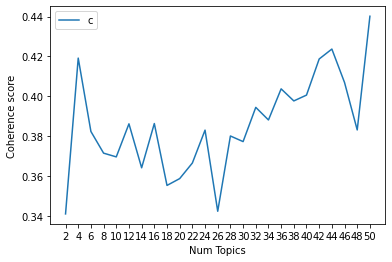

In [18]:
import matplotlib
import matplotlib.pyplot as plt

num_topics = [topics[0] for topics in coh_list]
coh_scores = [scores[1] for scores in coh_list]
plt.plot(num_topics, coh_scores)
plt.xlabel("Num Topics")
plt.xticks(num_topics)
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Finally , we can visualize the topics mined by the best LDA model using pyLDAvis

In [19]:
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(best_model, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster   Freq
topic                                            
40    -1.17e-01 -4.07e-01       1        1  14.34
36    -3.30e-01  3.30e-02       2        1   5.38
15    -5.85e-02 -2.05e-01       3        1   3.81
32    -1.75e-01  3.15e-02       4        1   2.70
5     -8.40e-02 -2.62e-02       5        1   2.61
9     -3.95e-02 -5.35e-02       6        1   2.45
39    -5.85e-02 -1.14e-02       7        1   2.09
45     3.56e-02 -7.18e-02       8        1   2.06
1      4.17e-02 -9.64e-03       9        1   2.03
16     3.64e-02 -3.75e-02      10        1   1.97
28     4.39e-02 -5.66e-02      11        1   1.92
37     3.81e-02 -1.03e-01      12        1   1.92
38    -1.51e-01  6.91e-02      13        1   1.89
29     4.77e-02 -5.89e-02      14        1   1.84
46    -1.26e-01  6.85e-02      15        1   1.84
11    -1.59e-02  1.59e-02      16        1   1.82
48     5.50e-02 -2.43e-02      17        1   1.80
42     2.64e-03 -1.08e-02      18        1   1.75
26     6.05e-02 -4.63e-02      19        1   1.71
25    -4.94e-02 -3.68e-03      20        1   1.70
20     5.19e-02 -3.01e-02      21        1   1.68
41    -2.58e-02  3.94e-02      22        1   1.68
13     6.06e-02 -6.63e-03      23        1   1.65
47     3.46e-02 -6.30e-03      24        1   1.62
34     4.33e-02 -6.48e-03      25        1   1.62
33     6.71e-02 -2.17e-02      26        1   1.58
6     -4.73e-02  5.77e-02      27        1   1.58
0      5.60e-02 -2.69e-03      28        1   1.57
49    -5.28e-02  6.26e-02      29        1   1.52
2      5.01e-02  1.34e-02      30        1   1.52
7     -1.15e-01  7.75e-02      31        1   1.49
30     6.86e-02  1.29e-02      32        1   1.48
19     5.75e-02 -2.41e-03      33        1   1.46
35     5.60e-02  1.02e-02      34        1   1.46
17     6.70e-02  1.94e-02      35        1   1.44
12    -5.28e-02  8.02e-02      36        1   1.42
22     6.15e-02 -3.62e-04      37        1   1.42
4     -8.36e-02  7.79e-02      38        1   1.34
27    -2.24e-02  6.52e-02      39        1   1.33
18     7.09e-02  1.98e-02      40        1   1.30
23     7.65e-02  2.52e-02      41        1   1.29
8      4.04e-02  3.31e-02      42        1   1.28
21     7.82e-02  3.89e-02      43        1   1.27
3      3.01e-02  5.64e-02      44        1   1.26
24    -5.31e-02  8.83e-02      45        1   1.25
14     7.70e-02  2.37e-02      46        1   1.24
43     4.28e-02  4.20e-02      47        1   1.22
44     4.60e-02  5.92e-02      48        1   1.17
10     7.76e-02  3.71e-02      49        1   1.12
31     8.29e-02  4.39e-02      50        1   1.10, topic_info=              Term      Freq     Total Category  logprob  loglift
0            china  35297.00  35297.00  Default    30.00    30.00
3          chinese  10993.00  10993.00  Default    29.00    29.00
9            state   3679.00   3679.00  Default    28.00    28.00
10          united   3295.00   3295.00  Default    27.00    27.00
11    united_state   2859.00   2859.00  Default    26.00    26.00
...            ...       ...       ...      ...      ...      ...
3437    television     41.67     42.90  Topic50    -4.66     4.48
27          blamed     40.72     41.95  Topic50    -4.68     4.48
5027    plan_build     39.04     40.27  Topic50    -4.72     4.47
2813          able     36.46     37.69  Topic50    -4.79     4.47
959           said     84.68   1153.13  Topic50    -3.95     1.89

[1640 rows x 6 columns], token_table=      Topic  Freq    Term
term                     
2813     50  0.96    able
1808     30  0.98  abroad
3279     30  0.98   abuse
5300     35  0.96  accept
505      34  0.99  access
...     ...   ...     ...
2876      4  0.98   young
5553      6  1.00    yuan
1539     33  0.98    zhou
1949     39  1.00    zone
1192     39  0.97     zoo

[1722 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[41, 37, 16, 33, 6, 10, 40, 46, 2, 17, 29, 38, 39, 30, 47, 12, 49, 43, 27, 26, 21, 42

# <span style="color:blue"><div align="center">Discussion of China related articles</div><span>
## We found the best number of topics = 50, and as we can see from the visualization in the previous cell:
## 1. Topic 1 is about the tensions in the south China sea
## 2. Topic 2 is about statements from chinese officials
## 3. Topic 12 is about China's involvement in the North Korea and South Korea tensions
## 4. Topic 39 is about tensions between China, Russia, and Japan
# Based on the overlap between a set of topics (e.g., topics 33, 37, 40, 43, 46, ... etc), I believe that there is room for improvement to achieve more accurate clustering of articles into topics

# Now lets filter all the titles related to <span style="color:blue">Middle East</span> using a list of related keywords <span style="color:blue">`middle_east_keywords = list(['egypt', 'palestine', 'israel', 'iraq', 'iran', 'arab', 'saudi', 'gaza', 'turk'])`</span>

# The filtered data frame <span style="color:blue">`filtered_df`</span> contains all related entries to China based on the list above. This dataframe will be used to build new dictionary and corpus

# We will try different values for the `num_topics` hyperparameter of the LDA model, and for each value we will store the trained model into `model_list`

In [21]:
middle_east_keywords = list(['egypt', 'palestine', 'israel', 'iraq', 'iran', 'arab', \
                            'saudi', 'gaza', 'turk'])

filtered_df = filter_by_entity(df, middle_east_keywords)
dictionary, corpus, doc2author = build_dictioanry_and_corpus(filtered_df)

print('Topic modeling on China related articles:')
print('Number of authors: ', len(filtered_df.author.unique()))
print('Number of unique words: ', len(dictionary))
print('Number of documents: ', len(corpus))
print()
print('First 10 Middle East related articles:')
print(filtered_df['title'].head(10))
print()

# num_topics 
num_topics = list(range(2,51, 2))
pool = multiprocessing.Pool()
model_list = pool.map(train_model, num_topics)

pool.close()
pool.join()
print('Finished!')

/home/ehussein/anaconda3/envs/my_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic modeling on China related articles:
Number of authors:  18687
Number of unique words:  63361
Number of documents:  82675

First 10 Middle East related articles:
2                                                                             US presses Egypt on Gaza border
15                      Nicolas Sarkozy, Angela Merkel confirm their opposition to Turkey being EU membership
22                                                    Merkel to meet leaders of Turkey, United Arab Emirates 
42                                                              Six killed in Israeli airstrike on Hamas base
48           Russia says an Iranian missile test this week raised suspicions over its true nuclear ambitions.
49                                                                    US says al-Qaida in Iraq using children
50    If Iran has 100% packet loss why does this website still load?  Also some interesting stories on there.
55                                                             

# Now lets calculate the c_v topics coherence score for each of the trained models


In [22]:
# calculate topics coherence
def calculate_coherence(models):
    coherence_list = list()
    for (model, num_topics) in models:
        # Compute Coherence Score using c_v
        coherence_model = CoherenceModel(model=model, texts=filtered_df['preprocessed_title'], \
                                             dictionary=dictionary, coherence='c_v')
        coherence_score_cv = coherence_model.get_coherence()
        print('\nCoherence Score (c_v): ', coherence_score_cv, ' and num_topics = ', num_topics)
        coherence_list.append((num_topics, coherence_score_cv))
    return coherence_list
    
coh_list = calculate_coherence(model_list)
print(coh_list)

/home/ehussein/anaconda3/envs/my_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score (c_v):  0.26450601940219287  and num_topics =  2

Coherence Score (c_v):  0.39523294020773014  and num_topics =  4

Coherence Score (c_v):  0.4121413186991372  and num_topics =  6

Coherence Score (c_v):  0.3652314371508326  and num_topics =  8

Coherence Score (c_v):  0.3761327410817218  and num_topics =  10

Coherence Score (c_v):  0.3452110343840544  and num_topics =  12

Coherence Score (c_v):  0.3319156292146161  and num_topics =  14

Coherence Score (c_v):  0.3283303580728115  and num_topics =  16

Coherence Score (c_v):  0.3272164236240815  and num_topics =  18

Coherence Score (c_v):  0.3266125643806592  and num_topics =  20

Coherence Score (c_v):  0.3153536672997266  and num_topics =  22

Coherence Score (c_v):  0.3113689746554735  and num_topics =  24

Coherence Score (c_v):  0.31167647185523467  and num_topics =  26

Coherence Score (c_v):  0.316386201381872  and num_topics =  28

Coherence Score (c_v):  0.30889067781188634  and num_topics =  30

Coherence 

# Now let's find the model that achieved the best topic coherence and save it to disk for latter use

In [23]:
best_num_topics, best_coherence = max(coh_list, key=lambda x: x[1])
best_model = None
for model, topics in model_list:
    if topics == best_num_topics:
        print(topics)
        best_model = model
        break

print('Best topics coherence: ', best_coherence)
print('Optimal number of topics = ', best_num_topics)

# Now print topics of best model
counter = 1
for topic in best_model.show_topics(num_topics=8):
    words = ''
    for word, prob in model.show_topic(topic[0]):
        words += word + ' '
    print('Topic ', counter, ' words: ' + words)
    counter += 1
    

# Save the best model.
model_filename = 'middle_east_top_model_' + str(best_num_topics) + '.atmodel'
best_model.save('./' + model_filename)
# Load model.
best_model = models.LdaModel.load('./' + model_filename)

6
Best topics coherence:  0.4121413186991372
Optimal number of topics =  6
Topic  1  words: israeli palestinian gaza police yemen coup year right soldier woman 
Topic  2  words: egypt president erdogan egyptian air death court journalist muslim top 
Topic  3  words: turkey state israel united say turkish united_state syria iranian military 
Topic  4  words: iraq iraqi isi attack force islamic killed mosul kurdish kill 
Topic  5  words: minister syrian israel west bank plan west_bank town settlement home 
Topic  6  words: iran saudi arabia saudi_arabia deal nuclear russia oil world netanyahu 


/home/ehussein/anaconda3/envs/my_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Let's visualize the topics coherence score vs the different numbers of topics

/home/ehussein/anaconda3/envs/my_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


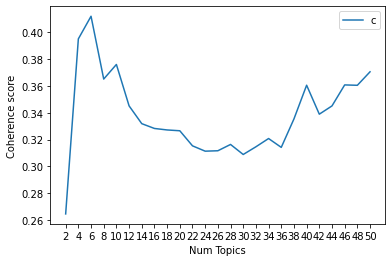

In [24]:
import matplotlib
import matplotlib.pyplot as plt

num_topics = [topics[0] for topics in coh_list]
coh_scores = [scores[1] for scores in coh_list]
plt.plot(num_topics, coh_scores)
plt.xlabel("Num Topics")
plt.xticks(num_topics)
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Finally , we can visualize the topics mined by the best LDA model using pyLDAvis

In [25]:
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(best_model, corpus, dictionary)
LDAvis_prepared

/home/ehussein/anaconda3/envs/my_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=          x         y  topics  cluster   Freq
topic                                        
2      0.40  1.13e-02       1        1  37.01
0     -0.02  1.13e-03       2        1  14.95
3     -0.11  3.64e-01       3        1  14.49
5     -0.13 -2.26e-01       4        1  13.64
1     -0.11 -3.89e-02       5        1  10.05
4     -0.02 -1.11e-01       6        1   9.87, topic_info=             Term      Freq     Total Category  logprob  loglift
51           iran  12352.00  12352.00  Default    30.00    30.00
251         saudi  10589.00  10589.00  Default    29.00    29.00
26        israeli   8432.00   8432.00  Default    28.00    28.00
17         turkey  16058.00  16058.00  Default    27.00    27.00
45           iraq   7152.00   7152.00  Default    26.00    26.00
...           ...       ...       ...      ...      ...      ...
473           vow    412.29    413.14   Topic6    -5.49     2.31
363          must    403.06    403.91   Topic6    -5.51     2.31
2727  cooperation    397.66    398.51   Topic6    -5.52     2.31
60         israel   1764.92  11925.75   Topic6    -4.03     0.40
153          news    658.63   1721.06   Topic6    -5.02     1.35

[233 rows x 6 columns], token_table=      Topic  Freq        Term
term                         
2044      2  1.00    activist
1410      5  1.00         air
3962      5  1.00  air_strike
4985      5  1.00     airport
626       5  1.00  airstrikes
...     ...   ...         ...
344       2  1.00       woman
235       4  1.00       world
988       1  0.36        year
988       2  0.64        year
2039      2  1.00       yemen

[228 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 6, 2, 5])

# <span style="color:blue"><div align="center">Discussion of Middle East related articles</div><span>
## We achieved the best topics coherence with `num_topics = 6`, and as we can see from the visualization in the previous cell:
## 1. Topic 1 is a big mixed topic, which is mainly about ISIS, U.S.A., Iraq, Iran, Israel and Turkey
## 2. Topic 2 is about the Israeli-Palestinian conflict
## 3. Topic 3 is about Iraq related news
## 4. Topic 4 is about Iran, its nuclear program, and its tension with neighbouring countries (e.g. Saudia Arabia)
## 5. Topic 5 is about Turkey, and its political tensions with Egypt
## 6. Topic 6 is about Israel, its prime minister, and its tensions with Palestine and neibouring countries (e.g., Syria and Iran)

# <span style="color:blue"><div align="center">Answering the second question</div><span>
# <span style="color:red"><div align="center">Given a title T, what are the most similar articles to T?</div><span>


## First, we compute the similarity matrix to query the model and find the most related articles to a given article

In [26]:
index = similarities.MatrixSimilarity(best_model[corpus])

/home/ehussein/anaconda3/envs/my_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# First, we list the first 10 articles related to Middle East
# Next, we select one of the shown articles to query its similar articles
# `print_related_documents` takes `article_id` of article T, and shows the `top_k` most related articles to T

In [27]:
print('First 10 Middle East related articles:')
print(filtered_df['title'].head(10))

def print_related_documents(article_id, top_k):
    vec_lda = best_model[corpus[article_id]]
    print()
    sims = index[vec_lda]
    sims = sorted(enumerate(sims), key=lambda item: -item[1])[0:top_k]
    for doc_position, doc_score in sims:
        print(doc_score, filtered_df['title'].iloc[doc_position])
    return

article_id = 4
top_k = 10

article_title = filtered_df['title'].iloc[article_id]
article_vector = filtered_df['preprocessed_title'].iloc[article_id]
print()
print('The', top_k, 'most related articles to: [', article_title, '] are:')
print_related_documents(article_id, top_k)

First 10 Middle East related articles:
2                                                                             US presses Egypt on Gaza border
15                      Nicolas Sarkozy, Angela Merkel confirm their opposition to Turkey being EU membership
22                                                    Merkel to meet leaders of Turkey, United Arab Emirates 
42                                                              Six killed in Israeli airstrike on Hamas base
48           Russia says an Iranian missile test this week raised suspicions over its true nuclear ambitions.
49                                                                    US says al-Qaida in Iraq using children
50    If Iran has 100% packet loss why does this website still load?  Also some interesting stories on there.
55                                                                            Israel plans Egypt border fence
74                                                     U.S.-Backed Russian Instit

/home/ehussein/anaconda3/envs/my_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
